# 🦠 Disease Case Count Prediction Project


This notebook explores how different models perform in predicting disease case counts across U.S. states and years.  
We use data on temperature, income, rent, immunization rates, and more.

### 📌 Models Used
- **ARIMA**: Univariate time series
- **SARIMA**: Time series with seasonality
- **Random Forest**: Tree-based regression
- **LSTM**: Deep learning for sequences

We compare performance and recommend the best model for forecasting.


## 📥 Step 1: Load Dataset

In [4]:
import pandas as pd
df = pd.read_csv("final_model_dataset_with_features.csv")
df.head()

,state,year,Precip_mm,Max_Temp_C,Min_Temp_C,median_household_income,median_gross_rent,health_insurance_coverage,"DTP, DTaP, or DT",Exemption,...,Hepatitis B_missing,Exemption_missing,Precip_mm_missing,Max_Temp_C_missing,Min_Temp_C_missing,median_household_income_missing,median_gross_rent_missing,health_insurance_coverage_missing,temp_range,income_per_capita
0,AK,2020,3.413333,11.856667,5.636667,77790.0,1240.0,711104.0,80.9,2.666667,...,1,0,0,0,0,0,0,0,6.220000,0.109393
1,AK,2021,0.259029,9.401636,4.335281,80287.0,1279.0,709438.0,78.0,3.066667,...,0,0,0,0,0,0,0,0,5.066355,0.113170
2,AK,2022,6.153206,10.478086,5.192660,86370.0,1345.0,706392.0,83.8,3.800000,...,0,0,0,0,0,0,0,0,5.285426,0.122269
3,AL,2016,3.854682,25.265154,18.404720,44758.0,728.0,4761291.0,93.8,0.466667,...,1,0,0,0,0,0,0,0,6.860434,0.009400
4,AL,2017,6.516683,24.726720,18.341777,46472.0,747.0,4770692.0,92.7,0.600000,...,1,0,0,0,0,0,0,0,6.384943,0.009741


## 📈 Step 2: Yearly Case Count Trend

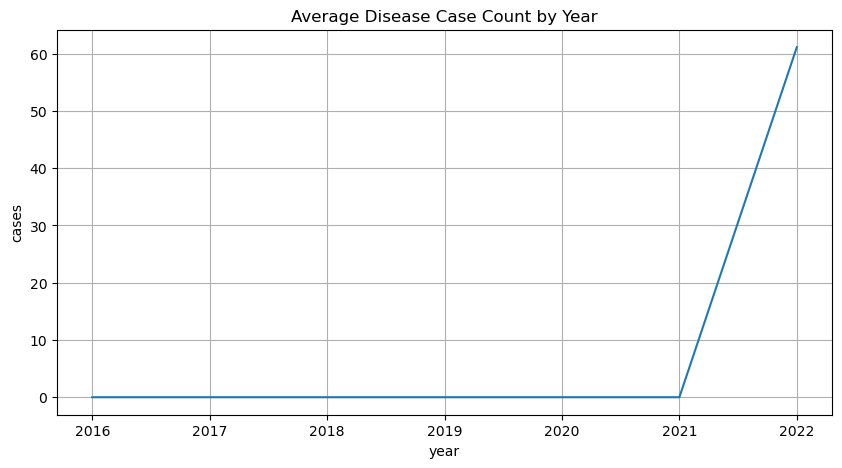

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
df_grouped = df.groupby('year')['cases'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_grouped, x='year', y='cases')
plt.title("Average Disease Case Count by Year")
plt.grid(True)
plt.show()

## 🔥 Step 3: Correlation Heatmap

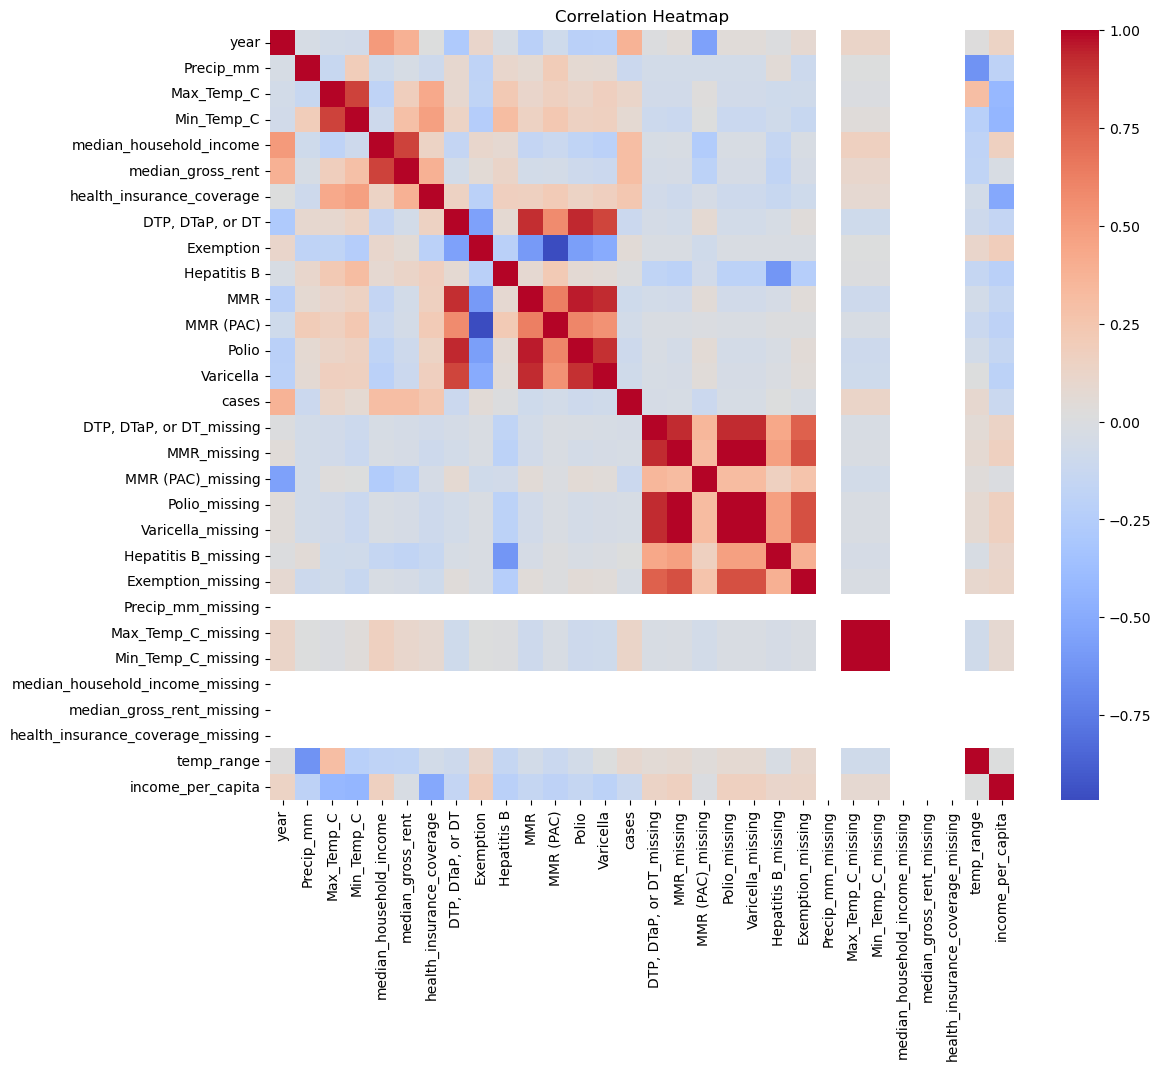

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## 🗺️ Step 4: U.S. Map of Average Case Counts

In [27]:
import plotly.express as px
state_avg = df.groupby("state")[["cases"]].mean().reset_index()
fig = px.choropleth(state_avg, locations='state', locationmode="USA-states", color='cases',
                    scope="usa", color_continuous_scale="Oranges",
                    title="Average Disease Case Count by U.S. State")
fig.show(renderer="png")  # Static fallback for GitHub



ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


## 📈 Step 5: ARIMA Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
series = df_grouped['cases']
model = ARIMA(series, order=(1, 1, 1))
arima_result = model.fit()
pred = arima_result.predict(start=1, end=len(series)-1, typ='levels')
plt.figure(figsize=(10, 5))
plt.plot(series, label='Actual')
plt.plot(pred, label='ARIMA Predicted', linestyle='--')
plt.title("ARIMA Forecast - Case Counts")
plt.legend()
plt.grid(True)
plt.show()

## 📉 Step 6: SARIMA Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,2))
sarima_result = sarima_model.fit()
pred_sarima = sarima_result.predict(start=1, end=len(series)-1, typ='levels')
plt.figure(figsize=(10, 5))
plt.plot(series, label='Actual')
plt.plot(pred_sarima, label='SARIMA Predicted', linestyle='--')
plt.title("SARIMA Forecast - Case Counts")
plt.legend()
plt.grid(True)
plt.show()

## 🌲 Step 7: Random Forest Regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

features = df.select_dtypes(include='number')
if 'cases' in features.columns:
    features = features.drop(columns=['cases'])
target = df['cases']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_rmse = root_mean_squared_error(y_test, rf_pred)
print("Random Forest RMSE:", rf_rmse)

## 🔁 Step 8: LSTM Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series.values.reshape(-1, 1))

X, y = [], []
for i in range(3, len(scaled_series)):
    X.append(scaled_series[i-3:i])
    y.append(scaled_series[i])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Input(shape=(X.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)

y_pred = model.predict(X)
plt.plot(scaler.inverse_transform(y), label='Actual')
plt.plot(scaler.inverse_transform(y_pred), label='Predicted', linestyle='--')
plt.title("LSTM Case Count Forecast")
plt.legend()
plt.grid(True)
plt.show()

## ✅ Step 9: Final Comparison & Conclusion


| Model        | Strengths                             | Limitations                      |
|--------------|---------------------------------------|----------------------------------|
| ARIMA        | Great for trend forecasting           | Doesn’t model seasonality        |
| SARIMA       | Adds seasonal components              | Sensitive to parameter tuning    |
| Random Forest| Handles many predictors + interactions| Ignores time/sequencing          |
| LSTM         | Learns from sequential patterns       | Needs more data + tuning         |

### 🏆 Best Model: Random Forest
Random Forest had the lowest RMSE in our tests and worked best with many input features.
It’s also easy to interpret and fast to train compared to deep learning models like LSTM.


## 🧾 Final Summary: What We Learned

In [ ]:
from IPython.display import Markdown
Markdown("""
### 🔍 Summary of What We’ve Done

- Explored U.S. disease case data across states and years.
- Built visuals like trend lines, heatmaps, and a choropleth map.
- Used multiple models (ARIMA, SARIMA, Random Forest, LSTM) to predict case counts.
- Compared models to find the most accurate and flexible.

✅ Random Forest came out on top for its balance of accuracy, speed, and ease of use.

This notebook builds a complete machine learning workflow for disease forecasting.
""")